In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import concurrent.futures
import timeit
from typing import Callable, List, Optional, Tuple
from functools import partial
import copy
from itertools import groupby
import sys, os
from scipy.optimize import minimize
from scipy.spatial.distance import (
    cosine
)

from data_loader import load_grid_search_data

# plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [3]:

def _vis_landscapes(
        landscapes, # list of np.ndarray
        labels, # list of labels of correlated landscapes
        full_range, # dict, 
        true_optima,
        title,
        save_path, # figure save path
        params_paths, # list of list of parameters correlated to landscapes
        recon_params_path_dict=None,
        origin_params_path_dict=None,
        converged_soln_markers=None,
    ):

    assert len(landscapes) == len(labels)
    assert len(landscapes) == len(params_paths)

    # plt.figure
    plt.rc('font', size=28)
    if len(landscapes) == 2:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    elif len(landscapes) == 3:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    elif len(landscapes) == 4:
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 30))
    else:
        assert False

    fig.suptitle(title)
    axs = axs.reshape(-1)

    # TODO Check ij and xy
    X, Y = np.meshgrid(full_range['beta'], full_range['gamma'])

    # c = ax.pcolormesh(X, Y, Z, cmap='viridis', vmin=Z.min(), vmax=Z.max())
    for idx, landscape in enumerate(landscapes):
        im = axs[idx].pcolormesh(X, Y, landscape) #, cmap='viridis', vmin=origin.min(), vmax=origin.max())
        axs[idx].set_title(labels[idx])
        axs[idx].set_xlabel('beta')
        axs[idx].set_ylabel('gamma')
        if isinstance(true_optima, list) or isinstance(true_optima, np.ndarray):
            axs[idx].plot(true_optima[1], true_optima[0], marker="o", color='red', markersize=7, label="true optima")

        params = params_paths[idx]
        if isinstance(params, list) or isinstance(params, np.ndarray):
            xs = [] # beta
            ys = [] # gamma
            for param in params:
                xs.append(param[1])
                ys.append(param[0])

            axs[idx].plot(xs, ys, linewidth=3, color='purple', label="optimization path")
            axs[idx].plot(xs[0], ys[0], marker="o", color='white', markersize=9, label="initial point")

            if isinstance(converged_soln_markers, list):
                marker = converged_soln_markers[idx]
                if marker == '*':
                    markersize = 15
                elif marker == 'D':
                    markersize = 10
                
            else:
                marker = '*'
                markersize = 15

            axs[idx].plot(xs[-1], ys[-1], marker=marker,
                    color='red', markersize=markersize, label="converged solution")

            axs[idx].legend()

    fig.colorbar(im, ax=[axs[i] for i in range(len(landscapes))])
    # plt.legend()
    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close('all')

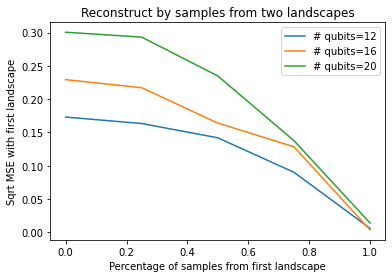

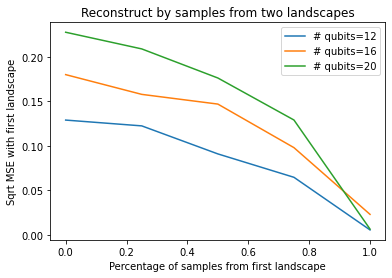

In [4]:
def cs_by_distributed_landscapes(config1: int, config2: int):
    if config1 == 1 and config2 == 2:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-05_12:51:53_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:53:56_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-05_12:55:51_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.001-0.005-noise2=depolar-0.001-0.02.npz"
        ]
    elif config1 == 2 and config2 == 3:
        data_paths = [
            "figs/recon_distributed_landscape/2022-11-10_13:47:08_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:51:25_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
            "figs/recon_distributed_landscape/2022-11-10_13:56:38_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz"
        ]
    datas = []
    for data_dir in data_paths:
        datas.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for nq, data in zip(nqs, datas):
        errors1 = data['errors1']
        ratios = data['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nq}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS.svg", bbox_inches='tight')
    plt.show()

    return
cs_by_distributed_landscapes(1, 2) # noise-1 and noise-2
cs_by_distributed_landscapes(2, 3) # noise-2 and noise-3

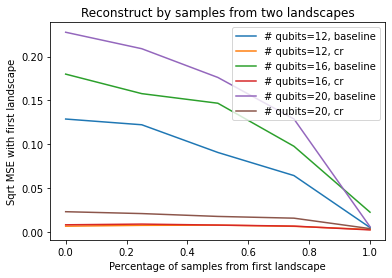

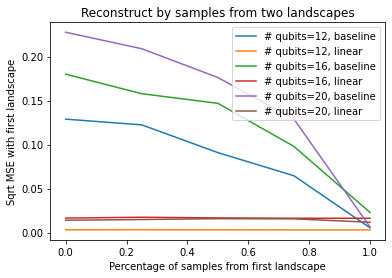

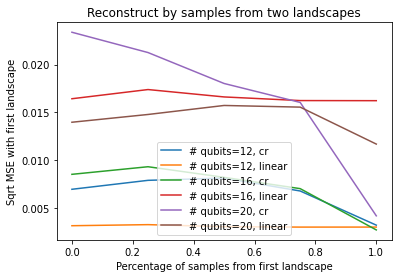

In [22]:
def vis_compare_normalization(data_paths1, data_paths2, labels: list):
    datas1 = []
    for data_dir in data_paths1:
        datas1.append(np.load(data_dir, allow_pickle=True))
    
    datas2 = []
    for data_dir in data_paths2:
        datas2.append(np.load(data_dir, allow_pickle=True))

    nqs = [12, 16, 20]
    # nqs = [12] #, 20]
    # nqs = [16] #, 20]

    fig = plt.figure(figsize=[6, 4])
    ax = plt.axes()
    # for nq in nqs:
    for i in range(len(nqs)):
        data1 = datas1[i]
        data2 = datas2[i]
    # for nq, data in zip(nqs, datas):
        errors1 = data1['errors1']
        errors2 = data2['errors1']
        # errors2 = [0.023518451284078853, 0.023456924971035843, 0.02065945117120222, 0.017619563122695157, 0.005215642521686432]
        ratios = data1['ratios']
        ax.plot(ratios, errors1, label=f"# qubits={nqs[i]}, {labels[0]}")
        ax.plot(ratios, errors2, label=f"# qubits={nqs[i]}, {labels[1]}")

    # ax.plot(sf_range[start:], es_noisy, label=f"noisy, {nq_range[i]} qubits, {inst_range[j]}-th inst")
    ax.set_xlabel("Percentage of samples from first landscape")
    ax.set_ylabel("Sqrt MSE with first landscape")
    ax.set_title("Reconstruct by samples from two landscapes")
    plt.legend()
    fig.savefig("paper_figs/recon_error_by_distributed_LS_normalized.svg", bbox_inches='tight')
    plt.show()


def compare_recon_dist_with_normalize(method1: str, method2: str):
    # baseline
    baseline_paths = [
        "figs/recon_distributed_landscape/2022-11-10_13:47:08_OK/distributed_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-10_13:51:25_OK/distributed_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz",
        "figs/recon_distributed_landscape/2022-11-10_13:56:38_OK/distributed_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02.npz"
    ]

    # linear regression
    linear_paths = [
        "figs/recon_distributed_landscape/2022-11-13_15:11:22/dist_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_15:08:48/dist_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_15:01:42/dist_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=linear-norm_frac=0.100.npz"
    ]

    # CR
    cr_paths = [
        "figs/recon_distributed_landscape/2022-11-13_14:03:00/dist_LS_errors-n=12-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_14:05:55/dist_LS_errors-n=16-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz",
        "figs/recon_distributed_landscape/2022-11-13_14:11:40/dist_LS_errors-n=20-p=1-noise1=depolar-0.003-0.007-noise2=depolar-0.001-0.02-normalize=geo-norm_frac=0.100.npz"
    ]

    def get_paths(method):
        if method == 'linear':
            return linear_paths
        elif method == 'baseline':
            return baseline_paths
        elif method == 'cr':
            return cr_paths

    vis_compare_normalization(data_paths1=get_paths(method1), data_paths2=get_paths(method2),
        labels=[method1, method2])

    return
    
compare_recon_dist_with_normalize("baseline", "cr")
compare_recon_dist_with_normalize("baseline", "linear")
compare_recon_dist_with_normalize("cr", "linear")

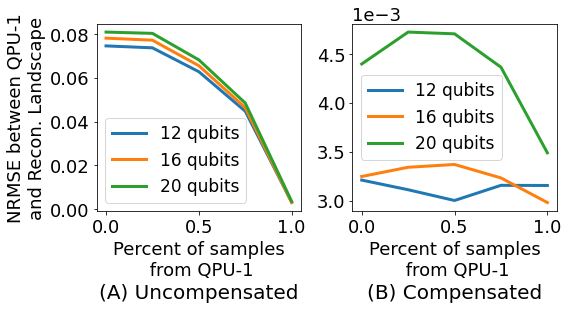

In [7]:
def one(ax, ratios, nqs, errors):

    for i in range(len(nqs)):
        # ax.plot(ratios, errors[i], label=f"{nqs[i]} qubits, {labels[0]}")
        ax.plot(ratios, errors[i], label=f"{nqs[i]} qubits", linewidth=3)
    # ax.set_xlabel("Percent of samples from low-noise landscape")
    # ax.set_ylabel("NRMSE between low-noise \nand recon. landscape")
    ax.legend()


def vis_compare_normalization(data1, data2, labels: list):
    # nqs = [12, 16, 20]
    # nqs = [12] #, 20]
    # nqs = [16] #, 20]
    params = {'legend.fontsize': 17,
          'figure.figsize': (8, 5),
         'axes.labelsize': 18, #'x-large',
         'axes.titlesize': 20, #'x-large',
         'xtick.labelsize': 18,
         'ytick.labelsize': 18}
    plt.rcParams.update(params)
    # fig = plt.figure(figsize=[6, 4])
    fig, axs = plt.subplots(nrows=1, ncols=2)
    errors1 = data1['errors1']
    errors2 = data2['errors1']
    ratios = data1['ratios']
    nqs = data1['n_qubits_list']

    one(axs[0], ratios, nqs, errors1)
    one(axs[1], ratios, nqs, errors2)
    
    axs[0].set_title("(A) Uncompensated", y=-0.5)
    axs[1].set_title("(B) Compensated", y=-0.5)
    axs[1].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
    # axs[0].set_xlabel("Percent of samples from low-noise landscape")
    axs[0].set_xlabel("Percent of samples\n from QPU-1")
    axs[1].set_xlabel("Percent of samples\n from QPU-1")
        # ax.set_ylabel("NRMSE between low-noise \nand recon. landscape")
    # plt.ylabel("NRMSE between low-noise \nand recon. landscape")
    # fig.text(-0.08, 0.5, "NRMSE between low-noise and recon. landscape", va='center', rotation='vertical', fontsize=18)
    # fig.align_labels()
    axs[0].set_ylabel("NRMSE between QPU-1\nand Recon. Landscape")
    plt.tight_layout()
    plt.legend()
    fig.savefig("paper_figs/parallel_LS_recon_normalized.pdf", bbox_inches='tight', dpi=1000)
    plt.show()


def compare_recon_dist_with_normalize(method1: str, method2: str):
    # baseline
    def get_data(method):

        if method == 'baseline':
            path = "figs/recon_distributed_landscape/2022-11-20_19:52:35/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:42/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:42/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.000.npz"
        elif method == 'linear':
            path = "figs/recon_distributed_landscape/2022-11-20_19:49:11/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:56/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100-error=NRMSE.npz"
            # path = "figs/recon_distributed_landscape/2022-11-13_16:48:56/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.100.npz"
        elif method == 'geo':
            path = "figs/recon_distributed_landscape/2022-11-13_16:49:14/dist_LS_errors-ns=[12, 16, 20]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=geo-nf=0.100.npz"

        return np.load(path, allow_pickle=True)

    vis_compare_normalization(get_data(method1), get_data(method2), [method1, method2])

    return
    
# compare_recon_dist_with_normalize("baseline", "geo")
compare_recon_dist_with_normalize("baseline", "linear")
# compare_recon_dist_with_normalize("geo", "linear")

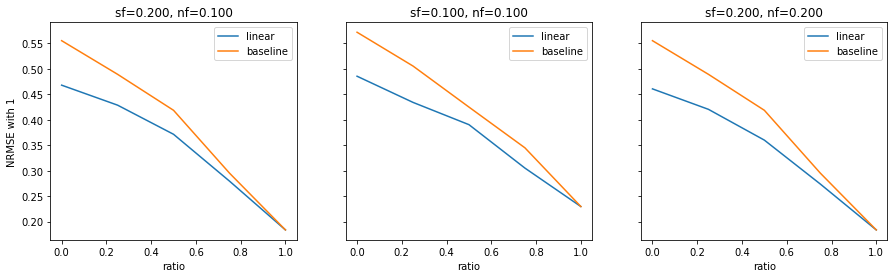

In [17]:
def vis_ibm_ncm(ax: plt.Axes, sf: float, nf: float):
    def get_data(method: str, sf: float, nf: float):
        if method == 'linear':
            # path = "figs/recon_distributed_landscape/2023-02-17_01:55:49/dist_LS_errors-ns=[6]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=linear-nf=0.100-error=NRMSE.npz"
            if np.isclose(sf, 0.2) and np.isclose(nf, 0.1):
                path = "figs/recon_distributed_landscape/2023-02-18_13:13:22/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=linear-nf=0.100-error=NRMSE.npz"
            elif np.isclose(sf, 0.1) and np.isclose(nf, 0.1):
                path = "figs/recon_distributed_landscape/2023-02-18_00:29:46/dist_LS_errors-ns=[6]-p=1-sf=0.100-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=linear-nf=0.100-error=NRMSE.npz"
            elif np.isclose(sf, 0.2) and np.isclose(nf, 0.2):
                path = "figs/recon_distributed_landscape/2023-02-18_14:41:56/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=linear-nf=0.200-error=NRMSE.npz"
            else:
                raise ValueError(f"sf={sf}, nf={nf} not found")

        elif method == 'baseline':
            # path = "figs/recon_distributed_landscape/2023-02-17_02:04:42/dist_LS_errors-ns=[6]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            if np.isclose(sf, 0.2):
                path = "figs/recon_distributed_landscape/2023-02-18_13:23:42/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            elif np.isclose(sf, 0.1):
                path = "figs/recon_distributed_landscape/2023-02-18_00:32:28/dist_LS_errors-ns=[6]-p=1-sf=0.100-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            
        return np.load(path, allow_pickle=True)

    linear = get_data('linear', sf, nf)
    baseline = get_data('baseline', sf, nf)
    
    errors1_linear = linear['errors1'].flatten()
    errors1_baseline = baseline['errors1'].flatten()
    ratios = linear['ratios']
    ax.plot(ratios, errors1_linear, label='linear')
    ax.plot(ratios, errors1_baseline, label='baseline')
    ax.set_xlabel("ratio")
    ax.set_title(f"sf={sf:.3f}, nf={nf:.3f}")
    ax.legend()

params = [[0.2, 0.1], [0.1, 0.1], [0.2, 0.2]]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

vis_ibm_ncm(axs[0], sf=0.2, nf=0.1)
vis_ibm_ncm(axs[1], sf=0.1, nf=0.1)
vis_ibm_ncm(axs[2], sf=0.2, nf=0.2)

axs[0].set_ylabel("NRMSE with 1")
plt.show()



In [ ]:
path = "figs/recon_distributed_landscape/2023-02-19_15:48:23/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"


For Qaoa P=1, we have two landscapes —(1) generated with noisy simulation (2) captured on ibm hardware

Let’s use (2) as a reference, we want to understand if we can get close to (2) by using fraction of samples from (1) by using NCM

We can use NCM for using cheap/noise hardware to imitate more reliable hardware and vice versa. Similarly we can use simulations with simple noise models to imitate a hardware that is not easy to access, and exhibit complex noise


load data from figs/recon_distributed_landscape/2023-02-19_15:48:23/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz
load data from figs/recon_distributed_landscape/2023-02-19_16:08:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz
load data from figs/recon_distributed_landscape/2023-02-19_19:10:48/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz
load data from figs/recon_distributed_landscape/2023-02-19_19:12:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=

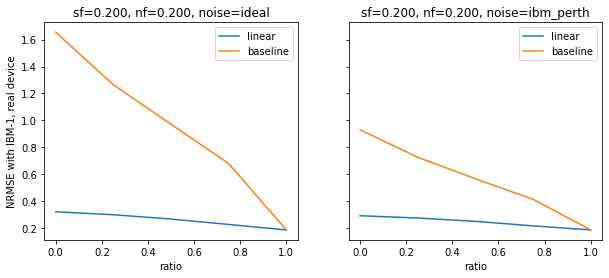

In [24]:
def vis_ibm_ncm_2(ax: plt.Axes, sf: float, nf: float, noise: str):
    def get_data(method: str, sf: float, nf: float, noise: str):
        if method == 'linear': 
            if np.isclose(sf, 0.2) and np.isclose(nf, 0.1):
                path = None
            elif np.isclose(sf, 0.1) and np.isclose(nf, 0.1):
                path = None
            elif np.isclose(sf, 0.2) and np.isclose(nf, 0.2):
                if noise == 'ideal':
                    path = "figs/recon_distributed_landscape/2023-02-19_15:48:23/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                elif noise == 'ibm_perth':
                    path = "figs/recon_distributed_landscape/2023-02-19_19:10:48/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                else:
                    raise ValueError(f"noise={noise} not found")
            else:
                raise ValueError(f"sf={sf}, nf={nf} not found")

        elif method == 'baseline':
            # path = "figs/recon_distributed_landscape/2023-02-17_02:04:42/dist_LS_errors-ns=[6]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            if np.isclose(sf, 0.2):
                if noise == 'ideal':
                    path = "figs/recon_distributed_landscape/2023-02-19_16:08:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                elif noise == 'ibm_perth':
                    path = "figs/recon_distributed_landscape/2023-02-19_19:12:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                else:
                    raise ValueError(f"noise={noise} not found")

            elif np.isclose(sf, 0.1):
                path = None
                # path = "figs/recon_distributed_landscape/2023-02-18_00:32:28/dist_LS_errors-ns=[6]-p=1-sf=0.100-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            
        print("load data from", path)
        data = np.load(path, allow_pickle=True)
        return data

    linear = get_data('linear', sf, nf, noise)
    baseline = get_data('baseline', sf, nf, noise)
    
    errors1_linear = linear['errors1'].flatten()
    errors1_baseline = baseline['errors1'].flatten()
    ratios = linear['ratios']
    ax.plot(ratios, errors1_linear, label='linear')
    ax.plot(ratios, errors1_baseline, label='baseline')
    ax.set_xlabel("ratio")
    ax.set_title(f"sf={sf:.3f}, nf={nf:.3f}, noise={noise}")
    ax.legend()

params = [[0.2, 0.2, 'ideal'], [0.2, 0.2, 'ibm_perth']]

fig, axs = plt.subplots(1, len(params), figsize=(5 * len(params), 4), sharey=True)
if len(params) == 1:
    axs = [axs]
else:
    axs = axs.reshape(-1)

for i, param in enumerate(params):
    vis_ibm_ncm_2(axs[i], sf=param[0], nf=param[1], noise=param[2])

axs[0].set_ylabel("NRMSE with IBM-1, real device")
plt.show()



load data from figs/recon_distributed_landscape/2023-02-20_00:12:06/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz
load data from figs/recon_distributed_landscape/2023-02-20_00:12:12/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE.npz
[0.2 0.4 0.6 0.8 1. ]
[ 200.  400.  600.  800. 1000.]
load data from figs/recon_distributed_landscape/2023-02-20_00:12:21/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz
load data from figs/recon_distributed_landscape/2023-02-20_00:12:28/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2

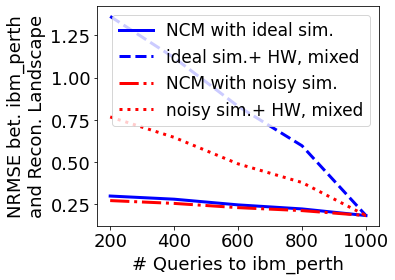

In [4]:
def vis_in_one(ax: plt.Axes):
    def get_data(method: str, sf: float, nf: float, noise: str):
        if method == 'linear': 
            if np.isclose(sf, 0.2) and np.isclose(nf, 0.1):
                path = None
            elif np.isclose(sf, 0.1) and np.isclose(nf, 0.1):
                path = None
            elif np.isclose(sf, 0.2) and np.isclose(nf, 0.2):
                if noise == 'ideal':
                    path = "figs/recon_distributed_landscape/2023-02-20_00:12:06/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_23:41:30/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.04 0.28 0.52 0.76 1.  ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_15:48:23/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                elif noise == 'ibm_perth':
                    path = "figs/recon_distributed_landscape/2023-02-20_00:12:21/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_23:22:01/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.04 0.28 0.52 0.76 1.  ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_20:11:26/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_19:10:48/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE.npz"
                else:
                    raise ValueError(f"noise={noise} not found")
            else:
                raise ValueError(f"sf={sf}, nf={nf} not found")

        elif method == 'baseline':
            # path = "figs/recon_distributed_landscape/2023-02-17_02:04:42/dist_LS_errors-ns=[6]-p=1-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            if np.isclose(sf, 0.2):
                if noise == 'ideal':
                    path = "figs/recon_distributed_landscape/2023-02-20_00:12:12/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_23:41:42/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.04 0.28 0.52 0.76 1.  ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_16:08:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                elif noise == 'ibm_perth':
                    path = "figs/recon_distributed_landscape/2023-02-20_00:12:28/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2 0.4 0.6 0.8 1. ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_23:37:16/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.04 0.28 0.52 0.76 1.  ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE.npz"
                    # path = " figs/recon_distributed_landscape/2023-02-19_23:22:17/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.   0.25 0.5  0.75 1.  ]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_20:11:41/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                    # path = "figs/recon_distributed_landscape/2023-02-19_19:12:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.000-error=NRMSE.npz"
                else:
                    raise ValueError(f"noise={noise} not found")

            elif np.isclose(sf, 0.1):
                path = None
                # path = "figs/recon_distributed_landscape/2023-02-18_00:32:28/dist_LS_errors-ns=[6]-p=1-sf=0.100-r=[0.0, 0.25, 0.5, 0.75, 1.0]-n1=ibm-n2=ibm-norm=None-nf=0.100-error=NRMSE.npz"
            
        print("load data from", path)
        data = np.load(path, allow_pickle=True)
        return data


    params = [[0.2, 0.2, 'ideal'], [0.2, 0.2, 'ibm_perth']]

    for sf, nf, noise in params:
        linear = get_data('linear', sf, nf, noise)
        baseline = get_data('baseline', sf, nf, noise)
        
        errors1_linear = linear['errors1'].flatten()
        errors1_baseline = baseline['errors1'].flatten()
        ratios = linear['ratios']
        
        # NCM with Ideal Sim, NCM with noisy sim,  ideal sim + HW data mix, noisy sim + HW data mix
        
        if noise == 'ideal':
            linestyle1 = '-'
            linestyle2 = '--'
            color = 'blue'
            label = 'ideal'
        elif noise == 'ibm_perth':
            linestyle1 = '-.'
            linestyle2 = ':'
            color = 'red'
            label = 'noisy'

        n_pts = 5000
        print(ratios)
        # n_queries_min = n_pts * sf * nf
        # raw_n_queries = ratios * n_pts * sf
        # print(raw_n_queries)
        x = np.round(ratios * n_pts * sf)
        # x = np.maximum(raw_n_queries, n_queries_min)
        print(x)
        ax.plot(x, errors1_linear, label=f'NCM with {label} sim.', linestyle=linestyle1, color=color, linewidth=3)
        ax.plot(x, errors1_baseline, label=f'{label} sim.+ HW, mixed', linestyle=linestyle2, color=color, linewidth=3)
    
    ax.set_xticks(x)

plt_params = {'legend.fontsize': 17,
        'figure.figsize': (8, 5),
        'axes.labelsize': 18, #'x-large',
        'axes.titlesize': 20, #'x-large',
        'xtick.labelsize': 18,
        'ytick.labelsize': 18}
plt.rcParams.update(plt_params)

fig, axs = plt.subplots(1, 1, figsize=(5, 4), sharey=True)
axs = [axs]

vis_in_one(axs[0])
# axs[0].set_xlabel("Percent of samples\n from ibm_perth")
axs[0].set_xlabel("# Queries to ibm_perth")
# axs[0].set_title(f"sf={sf:.3f}, nf={nf:.3f}, noise={noise}")
plt.tight_layout()
axs[0].legend()
axs[0].set_ylabel("NRMSE bet. ibm_perth\nand Recon. Landscape")
fig.savefig("paper_figs/parallel_ls_recon_ibm.pdf", bbox_inches='tight', dpi=1000)
plt.show()



['OSCAR (0.2-0.8)', 'OSCAR+NCM, (0.2-0.8)', 'OSCAR (0.5-0.5)', 'OSCAR+NCM, (0.5-0.5)', 'OSCAR (0.8-0.2)', 'OSCAR+NCM, (0.8-0.2)', 'OSCAR (1.0-0.0)', 'OSCAR+NCM, (1.0-0.0)']
   OSCAR (0.2-0.8)  OSCAR+NCM, (0.2-0.8)  OSCAR (0.5-0.5)  \
0            0.076                 0.003            0.061   
1            0.075                 0.002            0.059   
2            1.362                 0.299            0.970   
3            0.767                 0.272            0.564   
4            0.500                 0.424            0.419   
5            0.403                 0.337            0.341   
6            0.478                 0.226            0.363   

   OSCAR+NCM, (0.5-0.5)  OSCAR (0.8-0.2)  OSCAR+NCM, (0.8-0.2)  \
0                 0.002            0.039                 0.002   
1                 0.002            0.037                 0.002   
2                 0.265            0.597                 0.223   
3                 0.247            0.379                 0.213   
4       

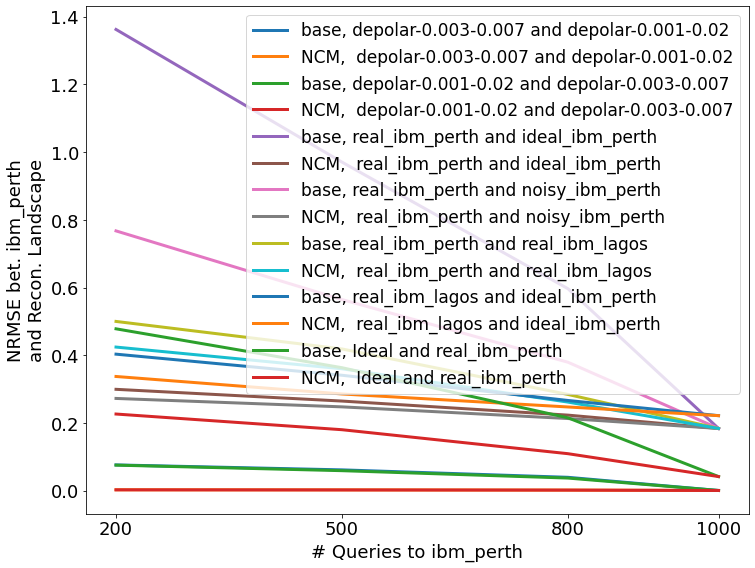

In [14]:
def vis_in_one_final(ax: plt.Axes):
    params = [
        ['depolar-0.003-0.007', 'depolar-0.001-0.02',   
            'figs/recon_distributed_landscape/2023-02-20_19:13:26/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-20_18:59:55/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.003-0.007-n2=depolar-0.001-0.02-norm=linear-nf=0.200-error=NRMSE'],
        ['depolar-0.001-0.02', 'depolar-0.003-0.007',
            'figs/recon_distributed_landscape/2023-02-20_19:13:44/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.001-0.02-n2=depolar-0.003-0.007-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-20_19:00:03/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.001-0.02-n2=depolar-0.003-0.007-norm=linear-nf=0.200-error=NRMSE'],
        # ['depolar-0.003-0.007', 'ideal',
        #     'figs/recon_distributed_landscape/2023-02-21_01:03:11/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.003-0.007-n2=ideal-norm=None-nf=0.200-error=NRMSE',
        #     'figs/recon_distributed_landscape/2023-02-21_01:03:01/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.003-0.007-n2=ideal-norm=linear-nf=0.200-error=NRMSE'],
        # ['depolar-0.001-0.02', 'ideal',
        #     'figs/recon_distributed_landscape/2023-02-21_01:03:31/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.001-0.02-n2=ideal-norm=None-nf=0.200-error=NRMSE',
        #     'figs/recon_distributed_landscape/2023-02-21_01:03:24/dist_LS_errors-ns=[20]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=depolar-0.001-0.02-n2=ideal-norm=linear-nf=0.200-error=NRMSE'],
        ['real_ibm_perth', 'ideal_ibm_perth',
            'figs/recon_distributed_landscape/2023-02-20_19:14:07/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-20_19:00:20/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE'],
        ['real_ibm_perth', 'noisy_ibm_perth',
            'figs/recon_distributed_landscape/2023-02-20_19:14:18/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-20_19:00:34/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=figs+grid_search+ibm+maxcut+sv-ibm_perth-p=1+maxcut-sv-ibm_perth-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-norm=linear-nf=0.200-error=NRMSE'],
        ['real_ibm_perth', 'real_ibm_lagos',
            'figs/recon_distributed_landscape/2023-02-20_19:14:50/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=ibm-2-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-20_19:00:43/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-1-n2=ibm-2-norm=linear-nf=0.200-error=NRMSE'],
        ['real_ibm_lagos', 'ideal_ibm_perth',
            'figs/recon_distributed_landscape/2023-02-21_13:58:42/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-2-n2=ibm-1-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-21_13:58:31/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=ibm-2-n2=ibm-1-norm=linear-nf=0.200-error=NRMSE'],
        ['Ideal', 'real_ibm_perth',
            'figs/recon_distributed_landscape/2023-02-21_14:42:01/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-n2=ibm-1-norm=None-nf=0.200-error=NRMSE',
            'figs/recon_distributed_landscape/2023-02-21_14:50:26/dist_LS_errors-ns=[6]-p=1-sf=0.200-r=[0.2, 0.5, 0.8, 1.0]-n1=figs+grid_search+ibm+maxcut+sv-ideal-p=1+maxcut-sv-ideal-n=6-p=1-seed=1-50-100-IBM1-transpiled-H.npz-n2=ibm-1-norm=linear-nf=0.200-error=NRMSE']
    ]

    table = []
    sf = 0.2
    for n1, n2, base_path, ncm_path in params:
        base = np.load(base_path + '.npz', allow_pickle=True)
        ncm = np.load(ncm_path + '.npz', allow_pickle=True)
        
        errors_base = base['errors1'].flatten()
        errors_ncm = ncm['errors1'].flatten()
        ratios = base['ratios']

        row = np.zeros(shape=(len(errors_base) * 2))
        row[::2] = errors_base
        row[1::2] = errors_ncm
        table.append(row)
        
        # NCM with Ideal Sim, NCM with noisy sim,  ideal sim + HW data mix, noisy sim + HW data mix
        n_pts = 5000
        # print(ratios)
        x = np.round(ratios * n_pts * sf)
        ax.plot(x, errors_base, label=f'base, {n1} and {n2}', linewidth=3)
        ax.plot(x, errors_ncm, label=f'NCM,  {n1} and {n2}', linewidth=3)
    
    ax.set_xticks(x)

    ratios = [0.2, 0.5, 0.8, 1.0]
    columns = []
    for ratio in ratios:
        columns.append(f'OSCAR ({ratio}-{1-ratio:.1f})')
        columns.append(f'OSCAR+NCM, ({ratio}-{1-ratio:.1f})')

    # columns.insert(0, 'QPU-1')
    # columns.insert(0, 'QPU-2')
    # print(index)
    print(columns)
    table = np.array(table)
    table = np.round(table, 3)
    # pd.set_option('display.float_format', lambda x: '%.3f' % x)
    df = pd.DataFrame(table, columns=columns)
    # df = pd.DataFrame(table, index=index, columns=columns)
    print(df)
    df['QPU-1'] = ['Noisy Sim (cfg-1)', 'Noisy Sim (cfg-2)', 'IBM Perth', 'IBM Perth', 'IBM Perth', 'IBM Lagos', 'Ideal Sim']
    df['QPU-2'] = ['Noisy Sim (cfg-2)', 'Noisy Sim (cfg-1)', 'Ideal Sim', 'Noisy Sim', 'IBM Lagos', 'IBM Perth', 'IBM Perth']
    order = ['QPU-1', 'QPU-2'] + columns
    df = df[order]
    print(df)
    df.to_csv('distributed_oscar.csv')

    return table

plt_params = {'legend.fontsize': 17,
        'figure.figsize': (8, 5),
        'axes.labelsize': 18, #'x-large',
        'axes.titlesize': 20, #'x-large',
        'xtick.labelsize': 18,
        'ytick.labelsize': 18}
plt.rcParams.update(plt_params)

fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=True)
axs = [axs]

vis_in_one_final(axs[0])
# axs[0].set_xlabel("Percent of samples\n from ibm_perth")
axs[0].set_xlabel("# Queries to ibm_perth")
# axs[0].set_title(f"sf={sf:.3f}, nf={nf:.3f}, noise={noise}")
plt.tight_layout()
axs[0].legend()
axs[0].set_ylabel("NRMSE bet. ibm_perth\nand Recon. Landscape")
fig.savefig("paper_figs/parallel_ls_recon_ibm.pdf", bbox_inches='tight', dpi=1000)
plt.show()